# Deep riccy project


## Env creation


In [1]:
local_path = 'refcocog/images/'
local_annotations = 'refcocog/annotations/'

In [32]:
# imports

import json
import pickle
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torchmetrics as tm
import torchvision
from torchvision import ops
import stanza
from tqdm import tqdm

from transformers import ViTFeatureExtractor, VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
stanza.download('en',package='partut')
nlp = stanza.Pipeline(lang='en')

2023-06-02 17:12:58 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package  |
------------------------------
| tokenize        | partut   |
| mwt             | partut   |
| pos             | partut   |
| lemma           | partut   |
| depparse        | partut   |
| backward_charlm | 1billion |
| forward_charlm  | 1billion |
| pretrain        | partut   |

2023-06-02 17:12:58 INFO: File exists: /home/pappol/stanza_resources/en/tokenize/partut.pt
2023-06-02 17:12:58 INFO: File exists: /home/pappol/stanza_resources/en/mwt/partut.pt
2023-06-02 17:12:58 INFO: File exists: /home/pappol/stanza_resources/en/pos/partut.pt
2023-06-02 17:12:58 INFO: File exists: /home/pappol/stanza_resources/en/lemma/partut.pt
2023-06-02 17:12:59 INFO: File exists: /home/pappol/stanza_resources/en/depparse/partut.pt
2023-06-02 17:12:59 INFO: File exists: /home/pappol/stanza_resources/en/backward_charlm/1billion.pt
2023-06-02 17:12:59 INFO: File exists: /home/pappol/s

2023-06-02 17:13:00 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

2023-06-02 17:13:00 INFO: Using device: cuda
2023-06-02 17:13:00 INFO: Loading: tokenize
2023-06-02 17:13:01 INFO: Loading: pos
2023-06-02 17:13:02 INFO: Loading: lemma
2023-06-02 17:13:02 INFO: Loading: constituency
2023-06-02 17:13:02 INFO: Loading: depparse
2023-06-02 17:13:02 INFO: Loading: sentiment
2023-06-02 17:13:02 INFO: Loading: ner
2023-06-02 17:13:03 INFO: Done loading processors!


## Utilities


### Functions

In [4]:
def clear_caption(caption):
    caption = caption.replace('<s>', '')
    caption = caption.replace('</s>', '')
    return caption

In [5]:
def crop_yolo(yolo_output, img, index):
    x1 = yolo_output.xyxy[0][index][0].cpu().numpy()
    x1 = np.rint(x1)
    y1 = yolo_output.xyxy[0][index][1].cpu().numpy()
    y1 = np.rint(y1)
    x2 = yolo_output.xyxy[0][index][2].cpu().numpy()
    x2 = np.rint(x2)
    y2 = yolo_output.xyxy[0][index][3].cpu().numpy()
    y2 = np.rint(y2)

    cropped_img = img.crop((x1, y1, x2, y2))

    return cropped_img

In [6]:
def remove_of(sentence):
    if "side of" in sentence:
        index = sentence.find("side of")
        sentence = sentence[index+7:]
        return sentence
    if "handle of" in sentence:
        index = sentence.find("handle of")
        sentence = sentence[index+9:]
    if "bunch of" in sentence:
        index = sentence.find("bunch of")
        sentence = sentence[index+8:]
        return sentence
    if "corner of" in sentence:
        index = sentence.find("corner of")
        sentence = sentence[index+9:]
        return sentence
    if "end of" in sentence:
        index = sentence.find("end of")
        sentence = sentence[index+6:]
        return sentence
    if "half of" in sentence:
        index = sentence.find("half of")
        sentence = sentence[index+7:]
        return sentence
    if "edge of" in sentence:
        index = sentence.find("edge of")
        sentence = sentence[index+7:]
        return sentence
    if "back of" in sentence:
        index = sentence.find("back of")
        sentence = sentence[index+7:]
        return sentence
    if "smaller of" in sentence:
        index = sentence.find("smaller of")
        sentence = sentence[index+10:]
        return sentence
    if "piece of" in sentence:
        index = sentence.find("piece of")
        sentence = sentence[index+8:]
        return sentence
    if "wing of" in sentence:
        index = sentence.find("wing of")
        sentence = sentence[index+7:]

    if "front of" in sentence:
        index = sentence.find("front of")
        sentence = sentence[index+8:]
        return sentence
    if "back side of" in sentence:
        index = sentence.find("back side of")
        sentence = sentence[index+12:]
        return sentence
    if "pile of" in sentence:
        index = sentence.find("pile of")
        sentence = sentence[index+7:]
        return sentence
    if "pair of" in sentence:
        index = sentence.find("pair of")
        sentence = sentence[index+7:]
        return sentence
    if "pieces of" in sentence:
        index = sentence.find("pieces of")
        sentence = sentence[index+9:]
        return sentence
    if "intersection of" in sentence:
        index = sentence.find("intersection of")
        sentence = sentence[index+15:]
        return sentence
    if "middle of" in sentence:
        index = sentence.find("middle of")
        sentence = sentence[index+9:]
        return sentence
    if "patch of" in sentence:
        index = sentence.find("patch of")
        sentence = sentence[index+8:]
        return sentence
    if "couple of" in sentence:
        index = sentence.find("couple of")
        sentence = sentence[index+8:]
        return sentence
    if "slice of" in sentence:
        index = sentence.find("slice of")
        sentence = sentence[index+8:]
        return sentence
    if "tallest of" in sentence:
        index = sentence.find("tallest of")
        sentence = sentence[index+10:]
        return sentence
    if "kind of" in sentence:
        index = sentence.find("kind of")
        sentence = sentence[index+7:]
        return sentence
    if "that is" in sentence:
        index = sentence.find("that is")
        sentence = sentence[:index]
        return sentence
    if "part of" in sentence:
        index = sentence.find("part of")
        sentence = sentence[index+7:]
        return sentence
    if "corner of" in sentence:
        index = sentence.find("corner of")
        sentence = sentence[index+9:]
        return sentence
    if "half of" in sentence:
        index = sentence.find("half of")
        sentence = sentence[index+7:]
        return sentence
    if "top of" in sentence:
        index = sentence.find("top of")
        sentence = sentence[index+6:]
        return sentence
    return sentence

In [7]:
def sent_stanza_processing(sentence):
    sentence = sentence.lower()
    if sentence.startswith('there is '):
        sentence = 'the ' + sentence[9:]
    if sentence.startswith('this is '):
        sentence = sentence[9:]
    sentence = remove_of(sentence)

    nlp_sent = sentence.lower()

    # put the sentence in lower case
    # if the sentence does not start with "a" or "the" insert it
    x = nlp_sent.split(" ")
    if (x[0] != "the" and x[0] != "a"):
        nlp_sent = "the " + nlp_sent

    doc = nlp(nlp_sent)
    # print nlp dependencies
    # doc.sentences[0].print_dependencies()
    # print(input["sentences"]["raw"])
    root = ''
    phrase_upos = []
    # get heads of words
    heads = [sent.words[word.head -
                        1].text for sent in doc.sentences for word in sent.words]
    for sent in doc.sentences:
        for word in sent.words:
            # if it is a verbal phrase then take the nominal subject of the phrase
            if (word.deprel == 'nsubj' or word.deprel == 'nsubj:pass'):
                root = word.text
                return word.text
                # print(word.text)
                break
            # print(word)
            phrase_upos.append(word)
            # else take the root of the phrase
            if (word.head == 0):
                # print(word.text)
                return word.text
                # root=word.text
                # if the root is a verb
                if (word.upos == 'VERB'):
                    for w in reversed(phrase_upos):
                        # go back until you get a noun
                        if (w.upos == 'NN'):
                            return word.text
                            # print(w.text)

In [8]:
def get_root(yolo_output, sentence, model, yolo):
    root = sent_stanza_processing(sentence)
    # print(root)
    prompt_tokens = clip.tokenize(
        root, context_length=77, truncate=True).cuda()
    with torch.no_grad():
        prompt_features = model.encode_text(prompt_tokens).float()

    names = []
    for a in range(len(yolo_output.xyxy[0])):
        class_index = int(yolo_output.pred[0][a][5])
        label = yolo.names[class_index]
        names.append(label)
    tokens = clip.tokenize(names, context_length=77, truncate=True).cuda()
    with torch.no_grad():
        classes_features = model.encode_text(tokens).float()
    prompt_features /= prompt_features.norm(dim=-1, keepdim=True)
    classes_features /= classes_features.norm(dim=-1, keepdim=True)
    prompt_similarity = classes_features.cpu().numpy() @ prompt_features.cpu().numpy().T
    if prompt_similarity.shape[0] == 0:
        return "empty"
    rappresentation = np.argmax(prompt_similarity)

    interested_class = names[rappresentation]
    return interested_class

In [9]:
# given an image pad the image to fit the dimension of clip and fill the padding with the median color of the image

def padd_image(img):
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    old_image_width, old_image_height = img.size
    # create new image of desired size and color (blue) for padding
    if (old_image_height > 224 or old_image_width > 224):
        if (old_image_height > old_image_width):
            new_image_width = old_image_height
            new_image_height = old_image_height

        else:
            new_image_width = old_image_width
            new_image_height = old_image_width

        color = avg_color
        # color = (255,0,255)

        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)

        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    else:
        new_image_width = 224
        new_image_height = 224

        color = avg_color
        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)
        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    img = Image.fromarray(result)
    img = img.resize((224, 224))
    return img

In [10]:
# remove the id in the image name string
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append

    return string

In [11]:
# convert yolo format bbox into standard type
def convert_bbox(bbox, img):
    x1, y1, width, height = bbox
    x2, y2 = x1 + width, y1 + height

    # Verify coordinates
    if x1 < 0 or y1 < 0 or x2 > img.width or y2 > img.height:
        print("Bounding box fuori dai limiti dell'immagine!")
    else:
        return x1, y1, x2, y2

In [12]:
# yolo bbox include class and precision, drop them
def convert_yolo_bbox(bbox):
    return bbox[:4]

In [13]:
# test model on a number N of images and print metrics each tenth of the images
def test_on_n_images(model, dataset, N):
    model.reset_metrics()

    for i in range(0, N):
        input = dataset[i]
        image_path = split_string(input["file_name"])
        sentence = input["sentences"]["raw"]
        gt = input["bbox"]
        original_img = Image.open(local_path + image_path).convert("RGB")
        # print img dimensions and box coordinates
        bbox, img = model.evaluate(image_path, sentence, gt, original_img)

        if i % (N/10) == 0:
            print("Iteration: ", i)
            print(model.get_metrics())

In [29]:
# Validation function if given a dataframe runs the model parameter for the whole dataframe and prints the metrics
def validate(model, dataframe):
    model.reset_metrics()
    for i in tqdm(range(0, len(dataframe))):
        input = dataframe.iloc[i]
        image_path = split_string(input["file_name"])
        sentence = input["sentences"]["raw"]
        gt = input["bbox"]
        original_img = Image.open(local_path + image_path).convert("RGB")
        # print img dimensions and box coordinates
        model.evaluate(image_path, sentence, gt, original_img)

    print(model.get_metrics())

In [15]:
def test_on_one_image(model, dataframe, index):
    model.reset_metrics()

    input = dataframe.iloc[index]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]

    original_img = Image.open(local_path + image_path).convert("RGB")

    # print img dimensions and box coordinates
    bbox, _ =model.evaluate(image_path, sentence, gt, original_img)
    bbox = bbox.cpu().numpy()
    #show image with bbox and caption and gound truth
    %matplotlib inline
    plt.imshow(original_img)

    x1, y1, width, height = gt

    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='red', linewidth=2))
    
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='blue', linewidth=2))
    print(sentence)
    plt.show()

    print(model.get_metrics())

In [16]:
import random

#a function that given a list of models tests on a specific image and shows the results in a plot grid
def compare_models(models, dataframe, index):
    
    input = dataframe.iloc[index]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]

    bboxes = []

    original_img = Image.open(local_path + image_path).convert("RGB")
    for model in models:
        # print img dimensions and box coordinates
        bbox, _ =model.evaluate(image_path, sentence, gt, original_img)
        bbox = bbox.cpu().numpy()
        bboxes.append(bbox)
    
    #add all the bboxes to the plot and show image with label and gound truth
    for i in range(0, len(bboxes)):
        #rotating colors with random
        bbox= bboxes[i]
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2))
        #add lable for the model
        plt.text(bbox[0], bbox[1], models[i].name, fontsize=12, color=color)

### Metrics


In [17]:
# definition of recall metric
class Recall:
    def __init__(self):
        self.true_positives = 0
        self.false_negatives = 0

    def update(self, correct):
        if correct:
            self.true_positives += 1
        else:
            self.false_negatives += 1

    def compute(self):
        return self.true_positives / (self.true_positives + self.false_negatives)

    def reset(self):
        self.true_positives = 0
        self.false_negatives = 0

In [18]:
class Metrics:
    def __init__(self, model, name):
        self.name = name
        self.treshold = 0.5
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        ])
        # initialize torch tensor
        self.iou = torch.tensor([]).cuda()
        self.recall = Recall()
        self.model = model
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

    def update(self, predicted_bbox, target_bbox, predicted_image, target_image):
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)

        with torch.no_grad():
            # Preprocess the predicted image and compute the predicted embedding
            predicted_image = padd_image(predicted_image)
            image_tensor = self.transform(predicted_image)
            image_tensor = image_tensor.unsqueeze(
                0).cuda()  # Add batch dimension
            predicted_embedding = self.model.encode_image(image_tensor)

            # Preprocess the target image and compute the target embedding
            target_image = padd_image(target_image)
            target_image_tensor = self.transform(target_image)
            target_image_tensor = target_image_tensor.unsqueeze(
                0).cuda()  # Add batch dimension
            target_embedding = self.model.encode_image(target_image_tensor)

        similarity = torch.nn.functional.cosine_similarity(
            predicted_embedding, target_embedding)
        distance = torch.nn.functional.pairwise_distance(
            predicted_embedding, target_embedding)

        # convert bboxes into torch tensors
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)
        predicted_bbox = convert_yolo_bbox(predicted_bbox)
        actual_iou = ops.box_iou(predicted_bbox.unsqueeze(
            0).cuda(), target_bbox.unsqueeze(0).cuda())
        self.iou = torch.cat((self.iou, actual_iou), 0)
        # get iou value of the predicted bbox and the target bbox
        if actual_iou > self.treshold:
            self.recall.update(True)
        else:
            self.recall.update(False)
        self.cosine_similarity = torch.cat(
            (self.cosine_similarity, similarity), 0)
        self.euclidean_distance = torch.cat(
            (self.euclidean_distance, distance), 0)

    def to_string(self):
        mean_iou = torch.mean(self.iou)
        recall_at_05_iou = self.recall.compute()
        mean_cosine_similarity = torch.mean(self.cosine_similarity)
        mean_euclidean_distance = torch.mean(self.euclidean_distance)

        #convert to numpy and save
        self.iou = self.iou.cpu().numpy()
        self.cosine_similarity = self.cosine_similarity.cpu().numpy()
        self.euclidean_distance = self.euclidean_distance.cpu().numpy()

        np.savetxt(self.name+"_iou.csv", self.iou, delimiter=",")
        np.savetxt(self.name+"_cosine_similarity.csv", self.cosine_similarity, delimiter=",")
        np.savetxt(self.name+"_euclidean_distance.csv", self.euclidean_distance, delimiter=",")

        return f"Mean IoU: {mean_iou:.4f}, Recall@0.5 IoU: {recall_at_05_iou:.4f}, Mean Cosine Similarity: {mean_cosine_similarity:.4f}, Mean Euclidean Distance: {mean_euclidean_distance:.4f}"

    def reset(self):
        self.iou = torch.tensor([]).cuda()
        self.recall.reset()
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

### Dataset


In [19]:
# dataset class definition
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        # load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)

        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        # separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sentences')
        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        # merge the dataframes
        self.dataset = pd.merge(
            self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        # drop useless columns for cleaner and smaller dataset
        self.dataset = self.dataset.drop(columns=['segmentation', 'id', 'category_id_y', 'ref_id', 'index_x',
                                         'iscrowd', 'image_id_y', 'image_id_x', 'category_id_x', 'ann_id', 'sent_ids', 'index_y', 'area'])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
        return self.ann_frame.iloc[idx]

    def get_imgframe(self, idx):
        return self.img_frame.iloc[idx]

    def get_validation(self):
        return self.dataset[self.dataset['split'] == 'val']

    def get_test(self):
        return self.dataset[self.dataset['split'] == 'test']

    def get_train(self):
        return self.dataset[self.dataset['split'] == 'train']

In [20]:
# dataset loading test and dimension check
#dataset = Coco(local_annotations + 'instances.json',
#               local_annotations + "refs(umd).p")

#print(len(dataset))

In [21]:
# to test prints the dataframe that composes the dataset
#dataset.dataset

## Base model

In [22]:
# class that defines the baseline model

class VisualGrounding_baseline(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_baseline, self).__init__()
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load(
            'ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "baseline"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        

    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")
        
        for i in range(len(yolo_output.xyxy[0])):
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            text = clip.tokenize([sentence]).cuda()

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]

        if max_image is None:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()

## Baseline+stanza


In [23]:
# class that defines the baseline model

class VisualGrounding_stanza(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_stanza, self).__init__()
        self.local_path = local_path
        self.img_path = img_path
        # initialize models
        self.yolo = torch.hub.load(
            'ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)
        self.name = "stanza"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        

    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)

        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                continue
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            text = clip.tokenize([sentence]).cuda()

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]

        if max_image is None:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()

## Text to text model

In [24]:
# class that defines the baseline model

class VisualGrounding_ttt(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_ttt, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True).to(self.device)
        self.clip, self.preprocess = clip.load(clip_version)

        # text to text section
        self.text_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=20)
        self.text_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_model = VisionEncoderDecoderModel.from_pretrained('/home/pappol/Scrivania/deepLearning/Image_Captioning_VIT_Roberta_final_4')
        self.text_model.to(self.device)
        self.name = "text to image"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        

    def forward(self, img_path, sentence):
        similarity = torch.tensor([]).to(self.device)

        yolo_output = self.yolo(self.local_path+img_path)
        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)

        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)
        at_least_one = False

        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                continue
            at_least_one = True
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)
            #generate caption
            features = self.text_feature_extractor(img_cropped, return_tensors="pt").pixel_values.to(self.device)
            generated = self.text_model.generate(features)[0].to(self.device)
            caption = self.text_tokenizer.decode(generated)
            #caption = self.text_tokenizer.decode(self.text_model.generate(self.text_feature_extractor(img_cropped, return_tensors="pt").pixel_values.to(self.device))[0].to(self.device))
            caption = clear_caption(caption)
            caption = clip.tokenize([caption]).to(device=self.device)
            enbedding_gen = self.clip.encode_text(caption).to(self.device)

            #cosine similarity bwteen caption and sentence
            similarity = torch.cat((similarity, torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)), 0)

        #if no bbox is found set bbox to the whole image
        if at_least_one==False:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        #argmax to get the most similar caption
        index = torch.argmax(similarity)
        max_bbox = yolo_output.xyxy[0][index]
        max_image = crop_yolo(yolo_output, original_img, index)

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()

## Model evaluation and comparison


In [25]:
# dataset load
dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

In [26]:
# model load
baseline = VisualGrounding_baseline('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7974MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [33]:
validate(baseline, dataset.get_test())

100%|██████████| 9602/9602 [51:21<00:00,  3.12it/s]  

Mean IoU: 0.5564, Recall@0.5 IoU: 0.5575, Mean Cosine Similarity: 0.8907, Mean Euclidean Distance: 4.4089


In [34]:
stanza = VisualGrounding_stanza('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7974MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [35]:
validate(stanza, dataset.get_test())

100%|██████████| 9602/9602 [50:34<00:00,  3.16it/s]  

Mean IoU: 0.5695, Recall@0.5 IoU: 0.5818, Mean Cosine Similarity: 0.8926, Mean Euclidean Distance: 4.3333


In [31]:
text_to_text = VisualGrounding_ttt('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']


In [28]:
validate(text_to_text, dataset.get_test())

Mean IoU: 0.3524, Recall@0.5 IoU: 0.3365, Mean Cosine Similarity: 0.8184, Mean Euclidean Distance: 5.8927


Back of a black train car meant to carry liquid sitting still on the train tracks.


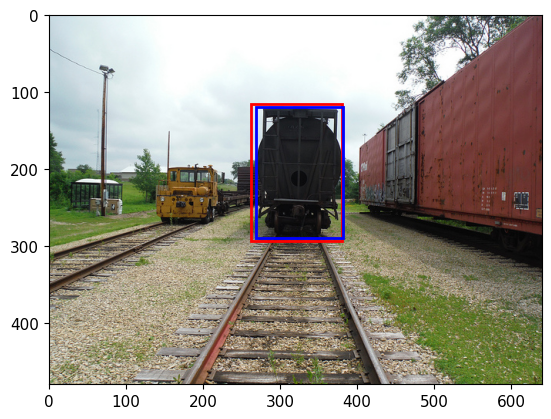

Mean IoU: 0.8992, Recall@0.5 IoU: 1.0000, Mean Cosine Similarity: 0.9702, Mean Euclidean Distance: 2.6621


: 

In [33]:
#test text to text model on one image

test_on_one_image(text_to_text, dataset.get_test(), 455)

Back of a black train car meant to carry liquid sitting still on the train tracks.


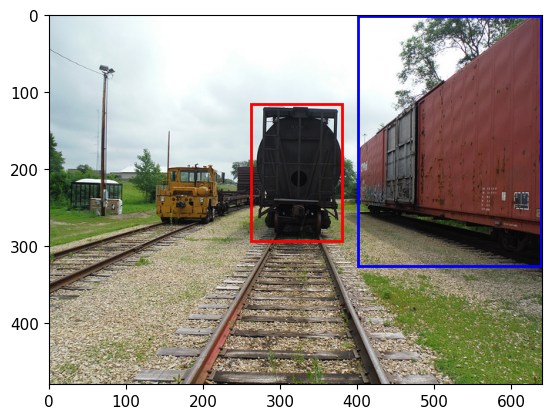

Mean IoU: 0.0000, Recall@0.5 IoU: 0.0000, Mean Cosine Similarity: 0.8296, Mean Euclidean Distance: 6.1367


In [74]:
test_on_one_image(baseline, dataset.get_test(), 455)

Back of a black train car meant to carry liquid sitting still on the train tracks.


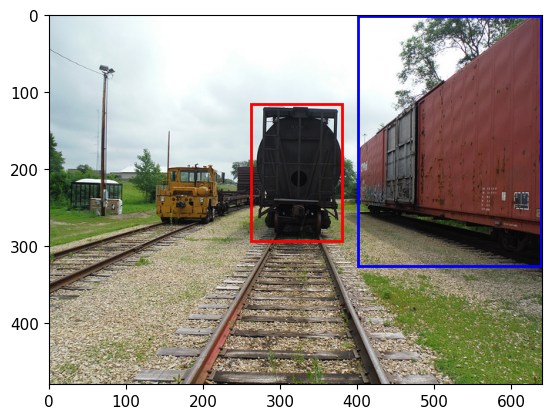

Mean IoU: 0.0000, Recall@0.5 IoU: 0.0000, Mean Cosine Similarity: 0.8296, Mean Euclidean Distance: 6.1367


In [75]:
test_on_one_image(stanza, dataset.get_test(), 455)